In [1]:
!wget https://datashare.is.ed.ac.uk/bitstream/handle/10283/3192/CINIC-10.tar.gz

--2020-05-10 11:40:48--  https://datashare.is.ed.ac.uk/bitstream/handle/10283/3192/CINIC-10.tar.gz
Resolving datashare.is.ed.ac.uk (datashare.is.ed.ac.uk)... 129.215.41.53
Connecting to datashare.is.ed.ac.uk (datashare.is.ed.ac.uk)|129.215.41.53|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 687544992 (656M) [application/gzip]
Saving to: ‘CINIC-10.tar.gz’

CINIC-10.tar.gz     100%[===================>] 655.69M  2.19MB/s    in 5m 1s   

2020-05-10 11:45:49 (2.18 MB/s) - ‘CINIC-10.tar.gz’ saved [687544992/687544992]



In [2]:
%%bash
mkdir 'CINIC-10'
tar -xvzf '/content/CINIC-10.tar.gz' -C '/content/CINIC-10'

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [0]:
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

import os
os.environ['KERAS_BACKEND'] = "tensorflow"
#TensorFlow: Channels last order.
#Theano: Channels first order.
#CNTK: Channels last order.

In [0]:
import matplotlib
#from matplotlib import pyplot as plt
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import imageio as im
from keras import models #vamos precisar desta biblioteca para aceder às camadas do modelo
from keras.models import load_model
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import Dropout
from keras.callbacks import ModelCheckpoint
from keras import backend as K
#K.set_image_dim_ordering('tf') 
K.image_data_format() == 'channels_last'
from keras.utils import np_utils
from keras.utils.data_utils import get_file
#from keras.datasets import mnist
import  tensorflow as tf
import keras.backend.tensorflow_backend as tfback

def _get_available_gpus():  

    if tfback._LOCAL_DEVICES is None:  
        devices = tf.config.list_logical_devices()  
        tfback._LOCAL_DEVICES = [x.name for x in devices]  
    return [x for x in tfback._LOCAL_DEVICES if 'device:gpu' in x.lower()]

tfback._get_available_gpus = _get_available_gpus

In [38]:
from keras.preprocessing.image import ImageDataGenerator
PATH = 'CINIC-10'

def load_cinic10():
    train_datagen = ImageDataGenerator(rescale=1./255
                                       )
    
    val_datagen = ImageDataGenerator(rescale=1./255)
    training_set = train_datagen.flow_from_directory(PATH+'/train',
                                                     target_size=(32, 32),
                                                     batch_size=64,
                                                     class_mode='categorical')  #tb podia ser class_mode='categorical'
    
    val_set = val_datagen.flow_from_directory(PATH+'/valid',
                                                target_size=(32, 32),
                                                batch_size=32,
                                                class_mode='categorical')
    
    test_set = val_datagen.flow_from_directory(PATH+'/test',
                                                target_size=(32, 32),
                                                batch_size=32,
                                                class_mode='categorical')
    
    return training_set, val_set, test_set

training_set, val_set, test_set = load_cinic10()
num_classes = 10
epochs = 25 #25

Found 90000 images belonging to 10 classes.
Found 90000 images belonging to 10 classes.
Found 90000 images belonging to 10 classes.


In [0]:
from keras.optimizers import SGD
from keras.constraints import maxnorm

def create_model_cnn_plus(num_classes,epochs):
    model = Sequential()
    model.add(Conv2D(32, (3, 3), input_shape=(32, 32, 3), activation='relu', padding='same'))
    model.add(Dropout(0.2))
    model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(Dropout(0.2))
    model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(Dropout(0.2))
    model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Flatten())
    model.add(Dropout(0.2))
    model.add(Dense(1024, activation='relu', kernel_constraint=maxnorm(3)))
    model.add(Dropout(0.2))
    model.add(Dense(512, activation='relu', kernel_constraint=maxnorm(3)))
    model.add(Dropout(0.2))
    model.add(Dense(num_classes, activation='softmax'))
    # Compile model
    lrate = 0.1
    decay = lrate/epochs
    sgd = SGD(lr=lrate, momentum=0.9, decay=decay, nesterov=False)
    model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])
    return model

model = create_model_cnn_plus(num_classes,epochs)

In [40]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_13 (Conv2D)           (None, 32, 32, 32)        896       
_________________________________________________________________
dropout_13 (Dropout)         (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 32, 32, 32)        9248      
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 16, 16, 64)        18496     
_________________________________________________________________
dropout_14 (Dropout)         (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 16, 16, 64)       

In [0]:
checkpointer = ModelCheckpoint(filepath="best_weights_t3.hdf5", monitor = 'val_accuracy', verbose=1, save_best_only=True)

In [42]:
history = model.fit_generator(training_set,
                            steps_per_epoch= 90000 // 64,
                            validation_data=val_set,
                            validation_steps= 90000 // 64, 
                            epochs=epochs, 
                            verbose=2, 
                            callbacks=[checkpointer])

Epoch 1/25
 - 53s - loss: 2.0685 - accuracy: 0.2179 - val_loss: 1.9657 - val_accuracy: 0.3149

Epoch 00001: val_accuracy improved from -inf to 0.31490, saving model to best_weights_t3.hdf5
Epoch 2/25
 - 53s - loss: 1.6707 - accuracy: 0.3744 - val_loss: 1.6104 - val_accuracy: 0.4070

Epoch 00002: val_accuracy improved from 0.31490 to 0.40696, saving model to best_weights_t3.hdf5
Epoch 3/25
 - 52s - loss: 1.5177 - accuracy: 0.4382 - val_loss: 1.5802 - val_accuracy: 0.4609

Epoch 00003: val_accuracy improved from 0.40696 to 0.46093, saving model to best_weights_t3.hdf5
Epoch 4/25
 - 53s - loss: 1.4226 - accuracy: 0.4779 - val_loss: 1.4298 - val_accuracy: 0.4796

Epoch 00004: val_accuracy improved from 0.46093 to 0.47955, saving model to best_weights_t3.hdf5
Epoch 5/25
 - 53s - loss: 1.3510 - accuracy: 0.5035 - val_loss: 1.4818 - val_accuracy: 0.5050

Epoch 00005: val_accuracy improved from 0.47955 to 0.50505, saving model to best_weights_t3.hdf5
Epoch 6/25
 - 53s - loss: 1.2934 - accuracy

In [0]:
model.load_weights('best_weights_t3.hdf5')

In [0]:
model.save('mnist_cnn_t3.h5')

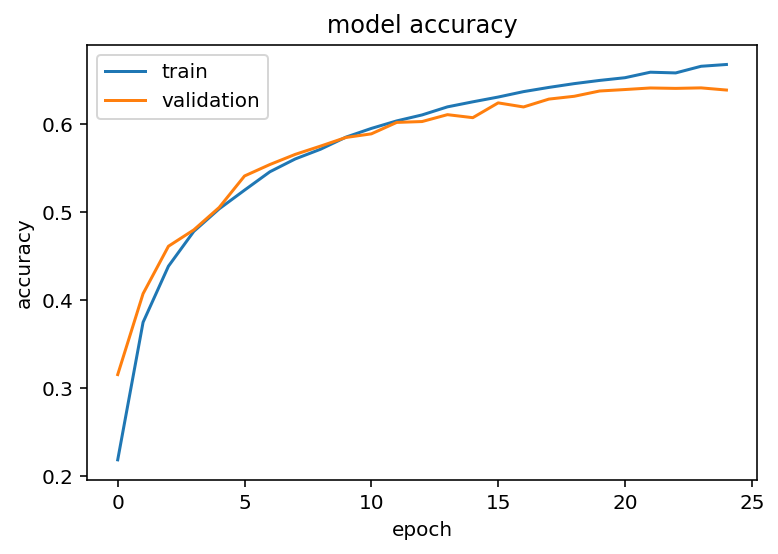

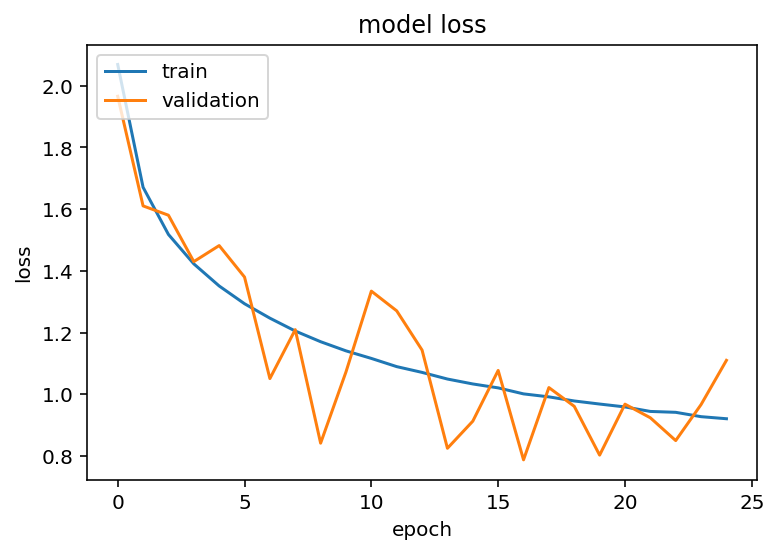

In [45]:
#funções para visulização do historial de aprendizagem
def print_history_accuracy(history):
    #print(history.history.keys())
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()

def print_history_loss(history):
    #print(history.history.keys())
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()

print_history_accuracy(history)
print_history_loss(history)

In [46]:
x, y = test_set.next()
print(x[0])
print(y[0])

[[[0.24705884 0.2509804  0.27058825]
  [0.4156863  0.41176474 0.43529415]
  [0.40000004 0.37254903 0.39607847]
  ...
  [0.3372549  0.32941177 0.32156864]
  [0.34509805 0.34509805 0.36078432]
  [0.25882354 0.2784314  0.31764707]]

 [[0.2392157  0.25490198 0.2901961 ]
  [0.3803922  0.35686275 0.38823533]
  [0.4666667  0.4431373  0.45098042]
  ...
  [0.3372549  0.3372549  0.3529412 ]
  [0.36078432 0.34901962 0.36862746]
  [0.24705884 0.27450982 0.3137255 ]]

 [[0.37647063 0.35686275 0.38823533]
  [0.427451   0.3647059  0.37647063]
  [0.30980393 0.29411766 0.31764707]
  ...
  [0.30588236 0.30980393 0.32941177]
  [0.24705884 0.27058825 0.30588236]
  [0.2392157  0.25490198 0.28627452]]

 ...

 [[0.454902   0.454902   0.4666667 ]
  [0.5882353  0.5529412  0.5647059 ]
  [0.6431373  0.6117647  0.60784316]
  ...
  [0.42352945 0.427451   0.454902  ]
  [0.6156863  0.54509807 0.5647059 ]
  [0.3803922  0.38431376 0.427451  ]]

 [[0.59607846 0.5529412  0.54509807]
  [0.72156864 0.65882355 0.64705884]


X_test: (32, 32, 32, 3)
y_test: (32, 10)
Imagem: (32, 32, 3)


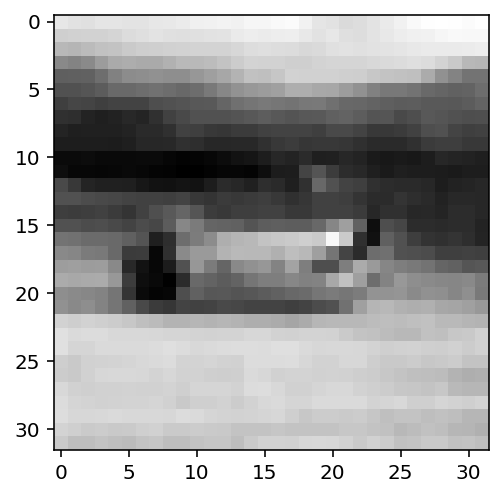

label: [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
antes do aumento de mais uma dimensão: (32, 32, 3)
depois do aumento de mais uma dimensão: (1, 32, 32, 3)
previsão: [[0.2678854  0.11774023 0.00511467 0.00414371 0.13588907 0.00834784
  0.00569522 0.01358212 0.42018673 0.02141502]]
Classe prevista: [8]


In [47]:
def visualize_previsao(x_test, y_test, img_a_mostrar):
    print("X_test:",x_test.shape)
    print("y_test:",y_test.shape)
    print("Imagem:",x_test[img_a_mostrar].shape)
    plt.imshow(x_test[img_a_mostrar,:,:,0], cmap='gray')
    plt.show()
    print("label:",y_test[img_a_mostrar])
    print("antes do aumento de mais uma dimensão:",x_test[img_a_mostrar].shape)
    imagem_tensor = np.expand_dims(x_test[img_a_mostrar], axis=0)
    print("depois do aumento de mais uma dimensão:",imagem_tensor.shape)
    print("previsão:",model.predict(imagem_tensor))
    classes = model.predict_classes(imagem_tensor)
    print('Classe prevista:',classes)
    return imagem_tensor

image_tensor = visualize_previsao(x, y, 20)

In [48]:
#Vamos buscar os outputs das primeiras 5 (plus) camadas da rede ou 12 para a plus_plus
camadas_outputs = []
for layer in model.layers[:12]:
    print(layer.output.shape)
    camadas_outputs.append(layer.output)

# e depois criamos um modelo que retorna estes outputs dado os inputs do modelo
activation_model = models.Model(inputs=model.input, outputs=camadas_outputs) 

(None, 32, 32, 32)
(None, 32, 32, 32)
(None, 32, 32, 32)
(None, 16, 16, 32)
(None, 16, 16, 64)
(None, 16, 16, 64)
(None, 16, 16, 64)
(None, 8, 8, 64)
(None, 8, 8, 128)
(None, 8, 8, 128)
(None, 8, 8, 128)
(None, 4, 4, 128)


In [0]:
activations = activation_model.predict(image_tensor) 
# Retorna uma lista com dois Numpy arrays: um array por camada de ativação

In [50]:
first_layer_activation = activations[0]
print(first_layer_activation.shape)

(1, 32, 32, 32)


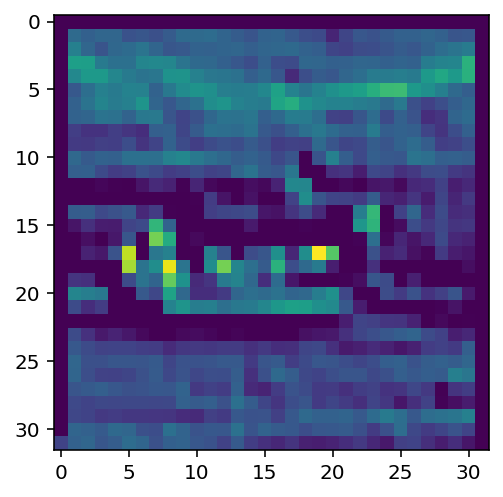

In [54]:
plt.imshow(first_layer_activation[0, :, :,3], cmap='viridis')
plt.show()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in true_divide
  app.launch_new_instance()


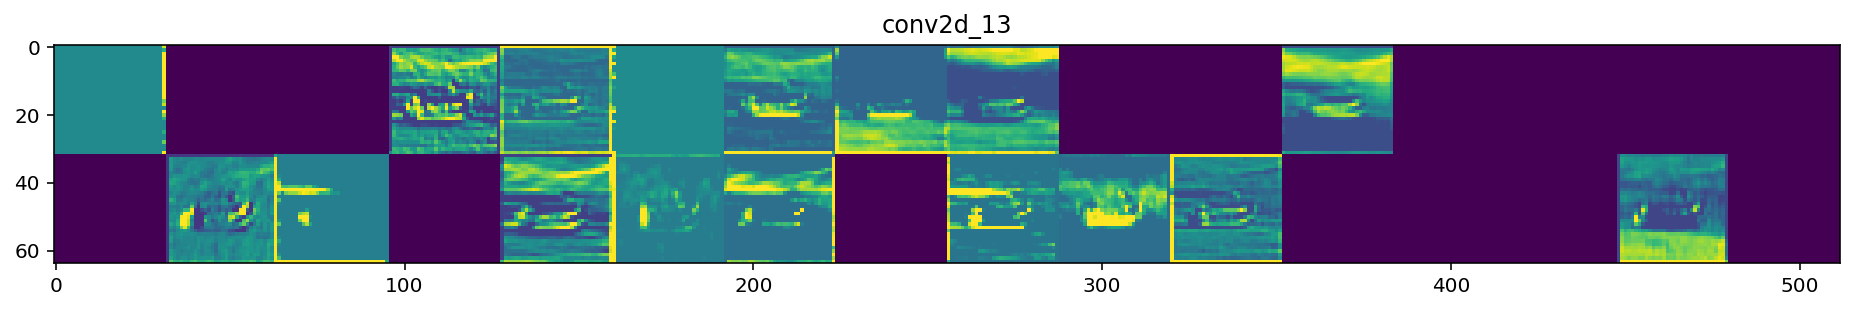

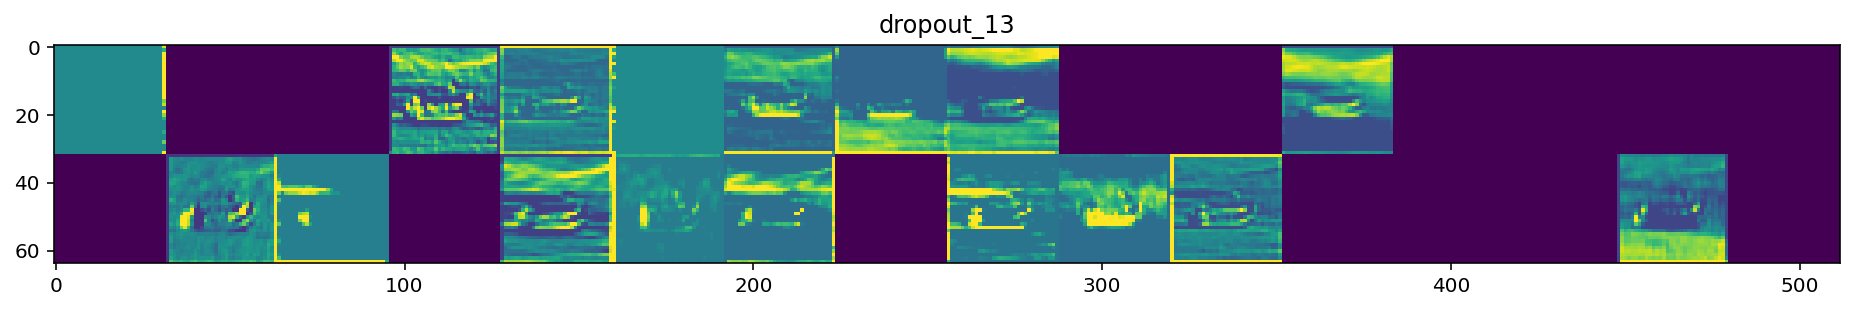

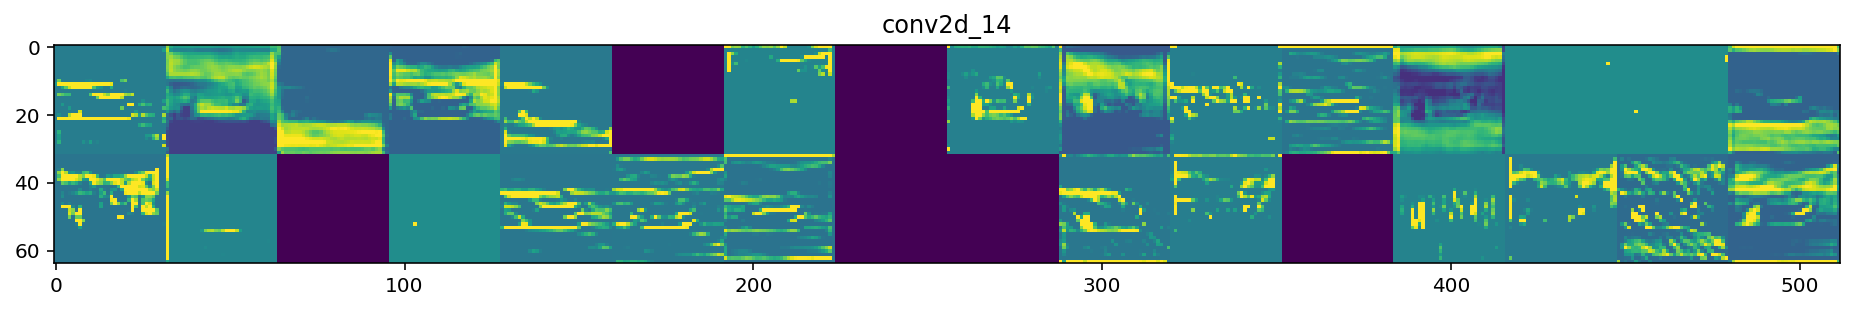

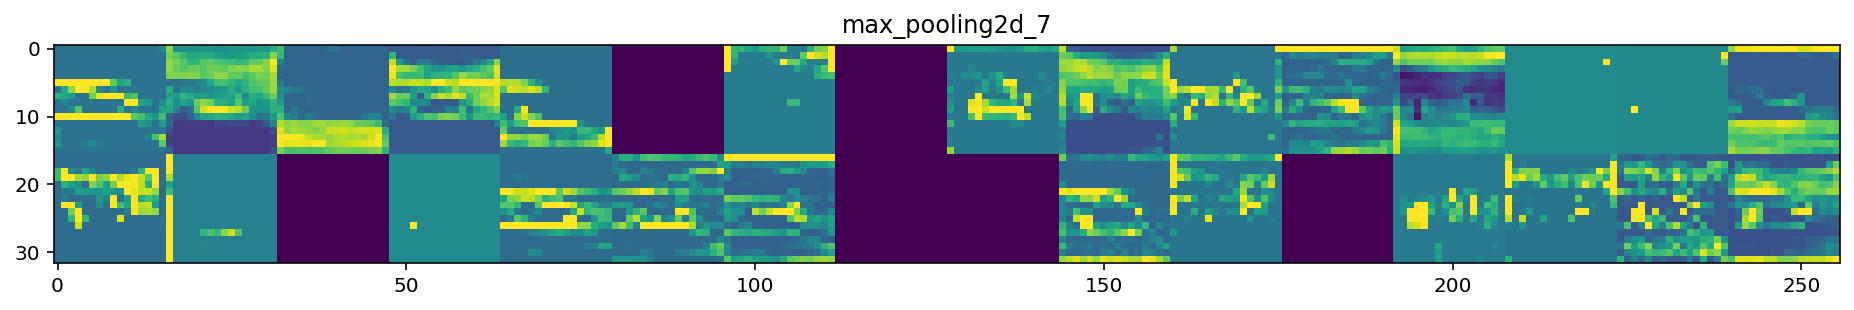

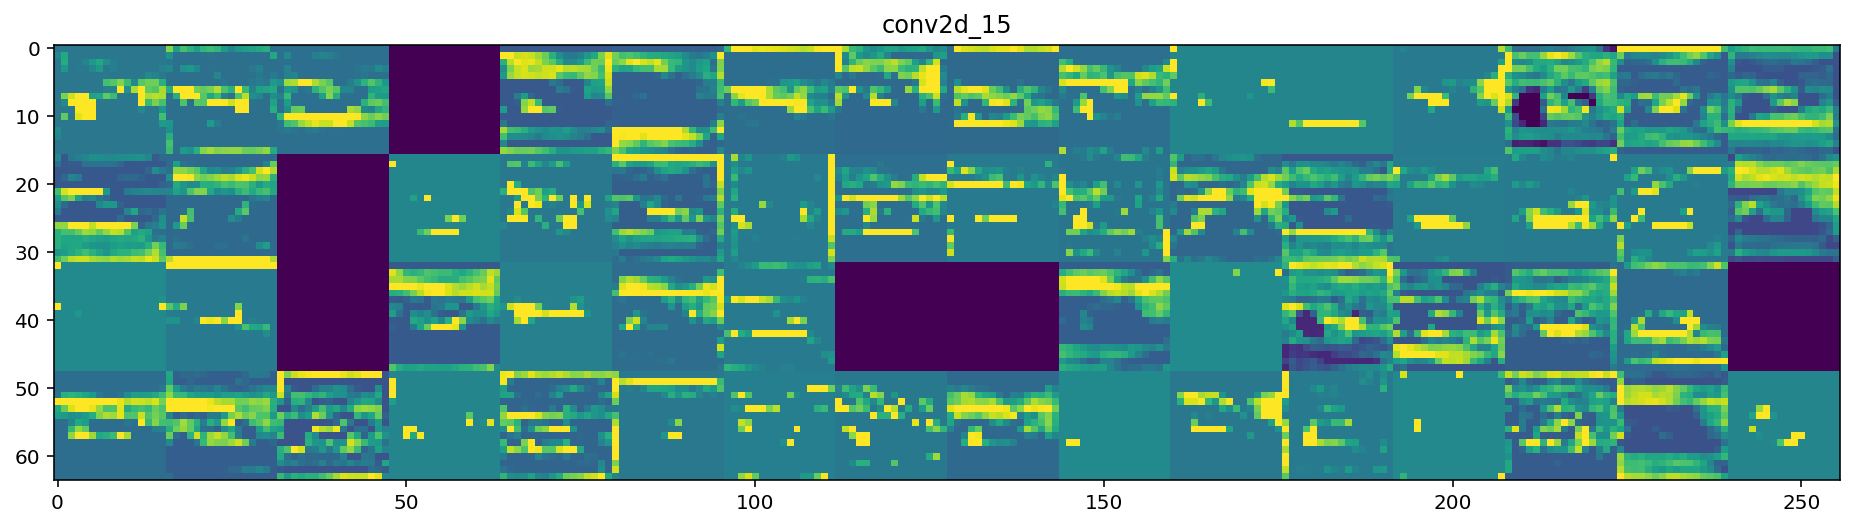

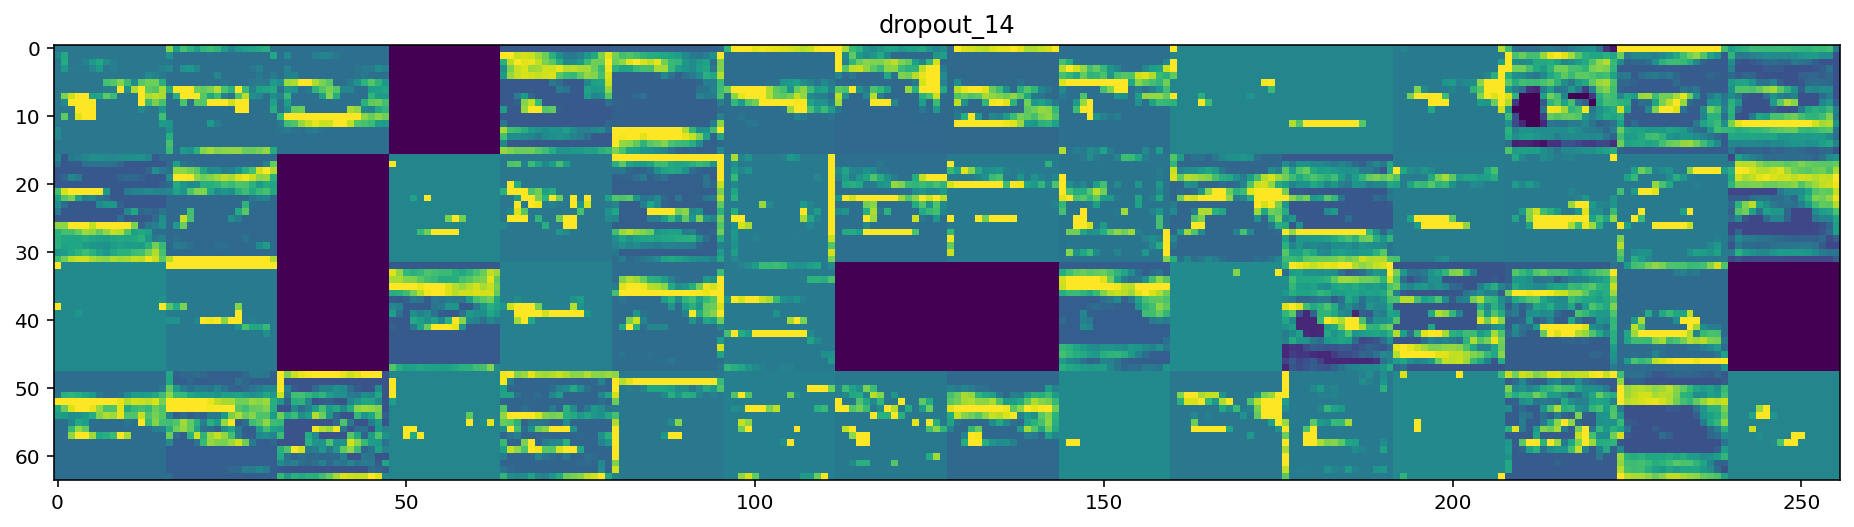

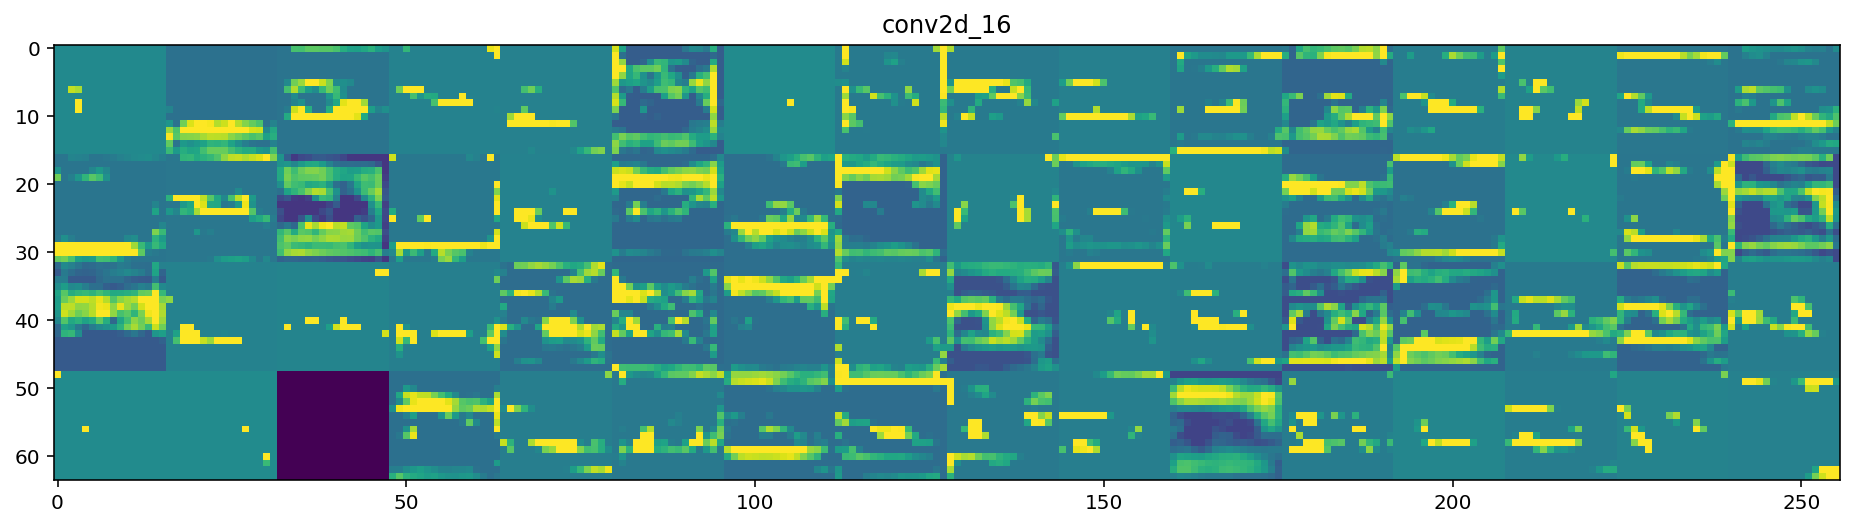

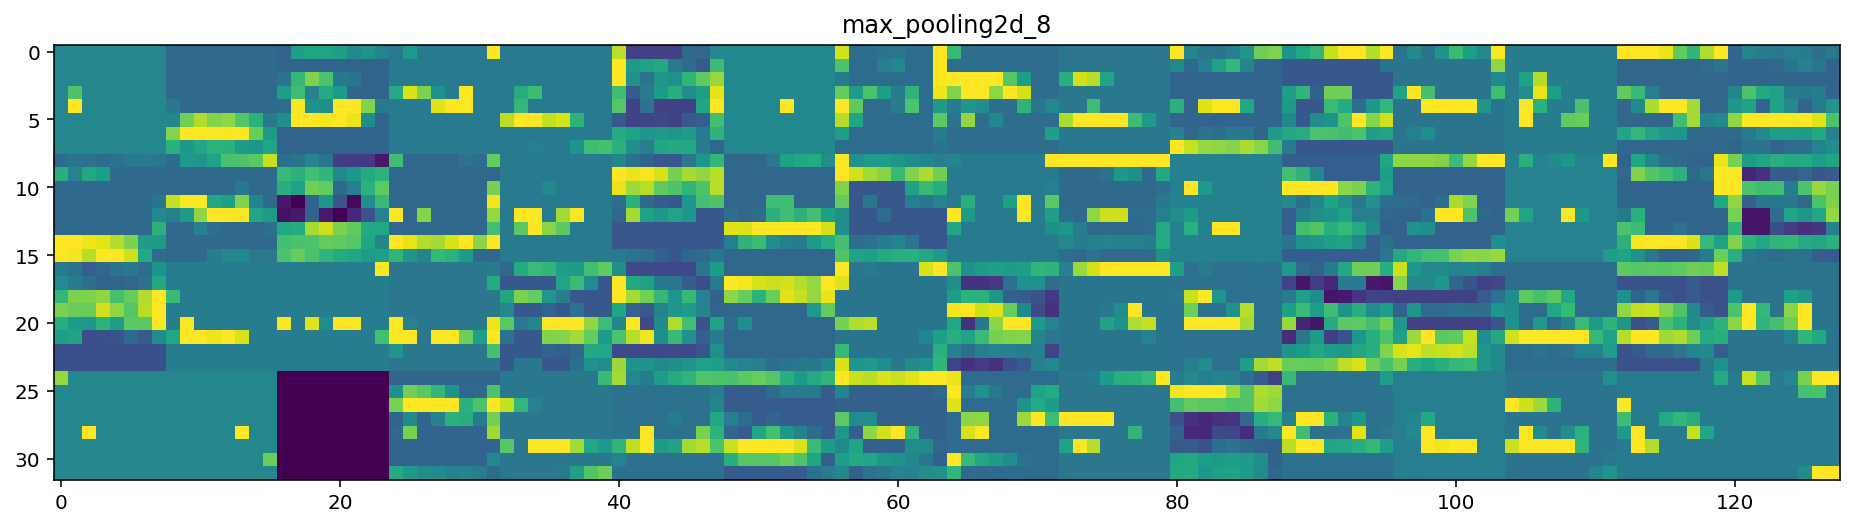

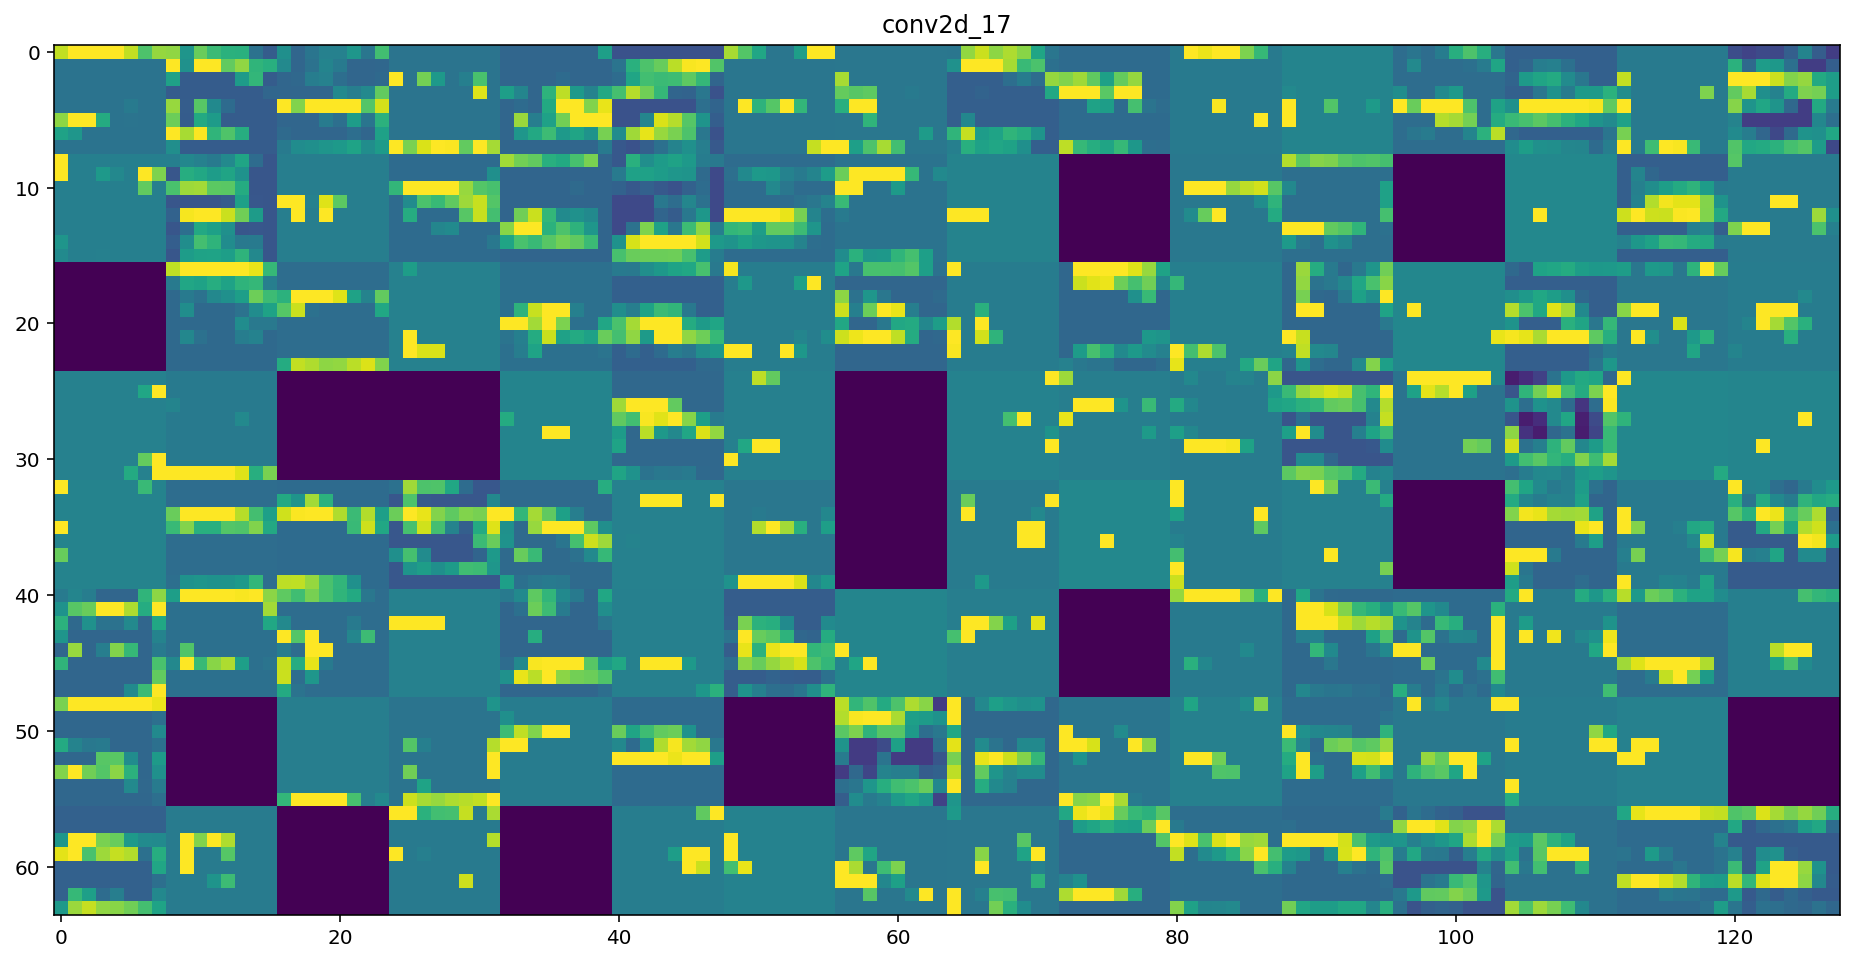

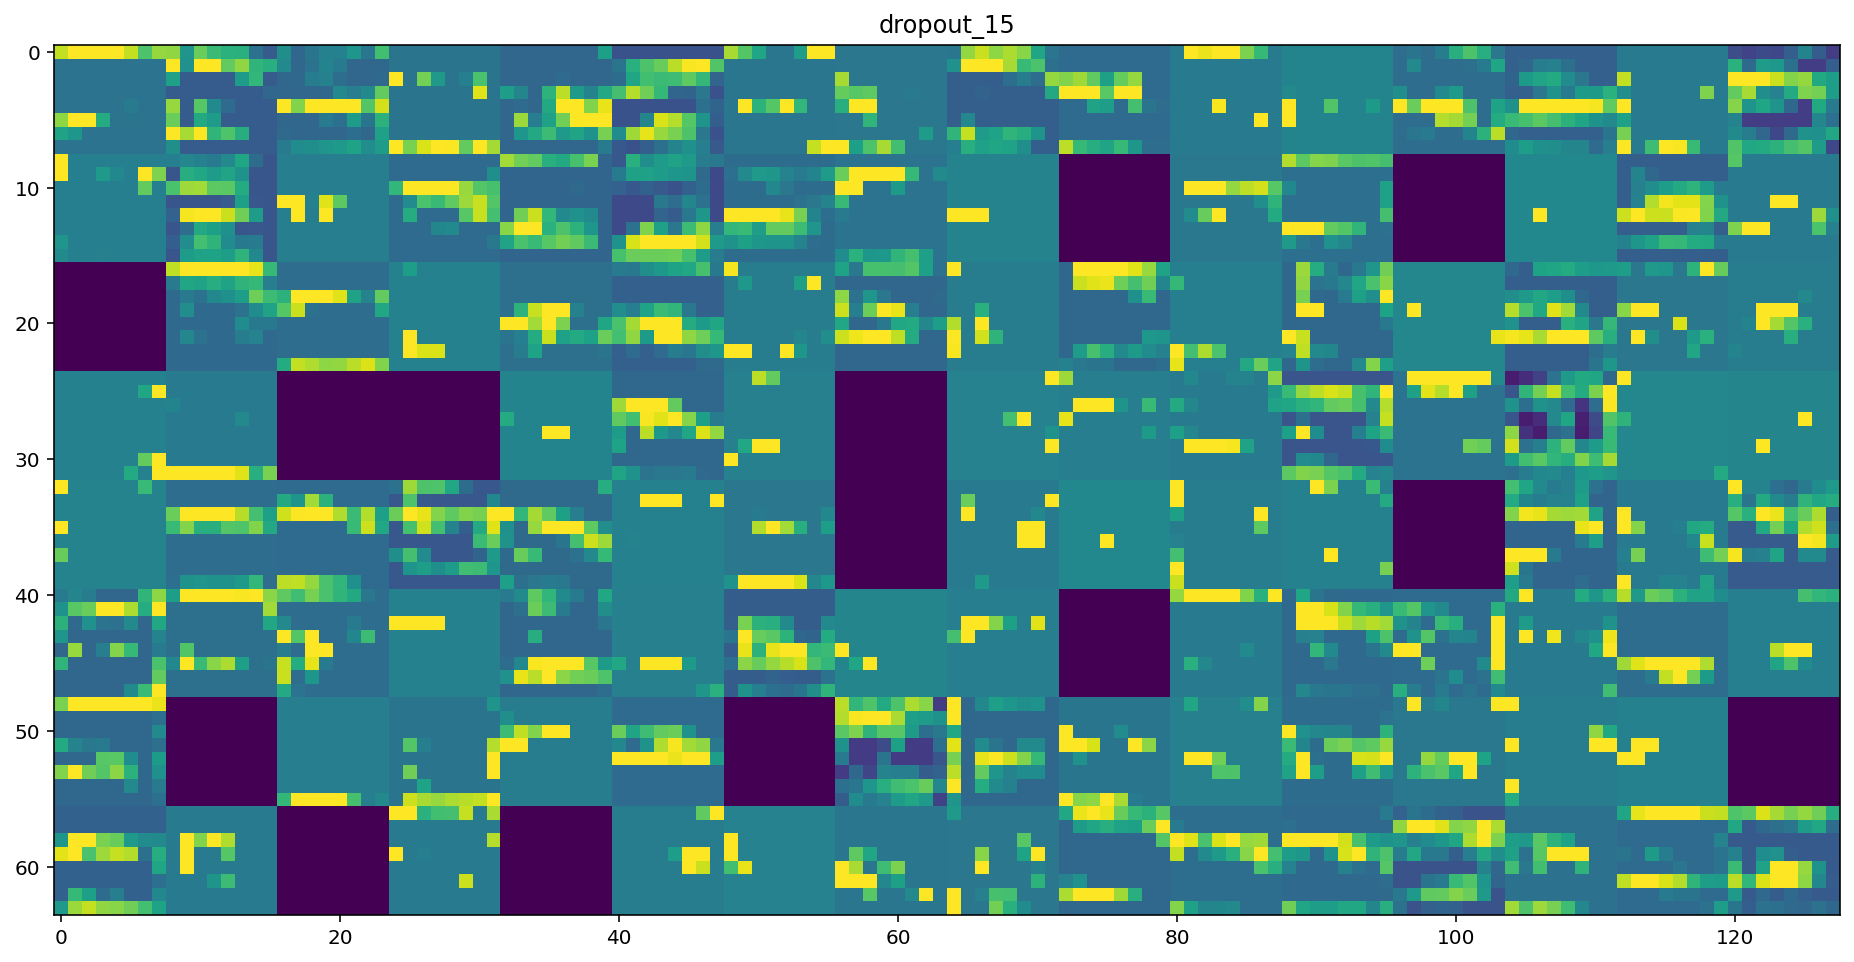

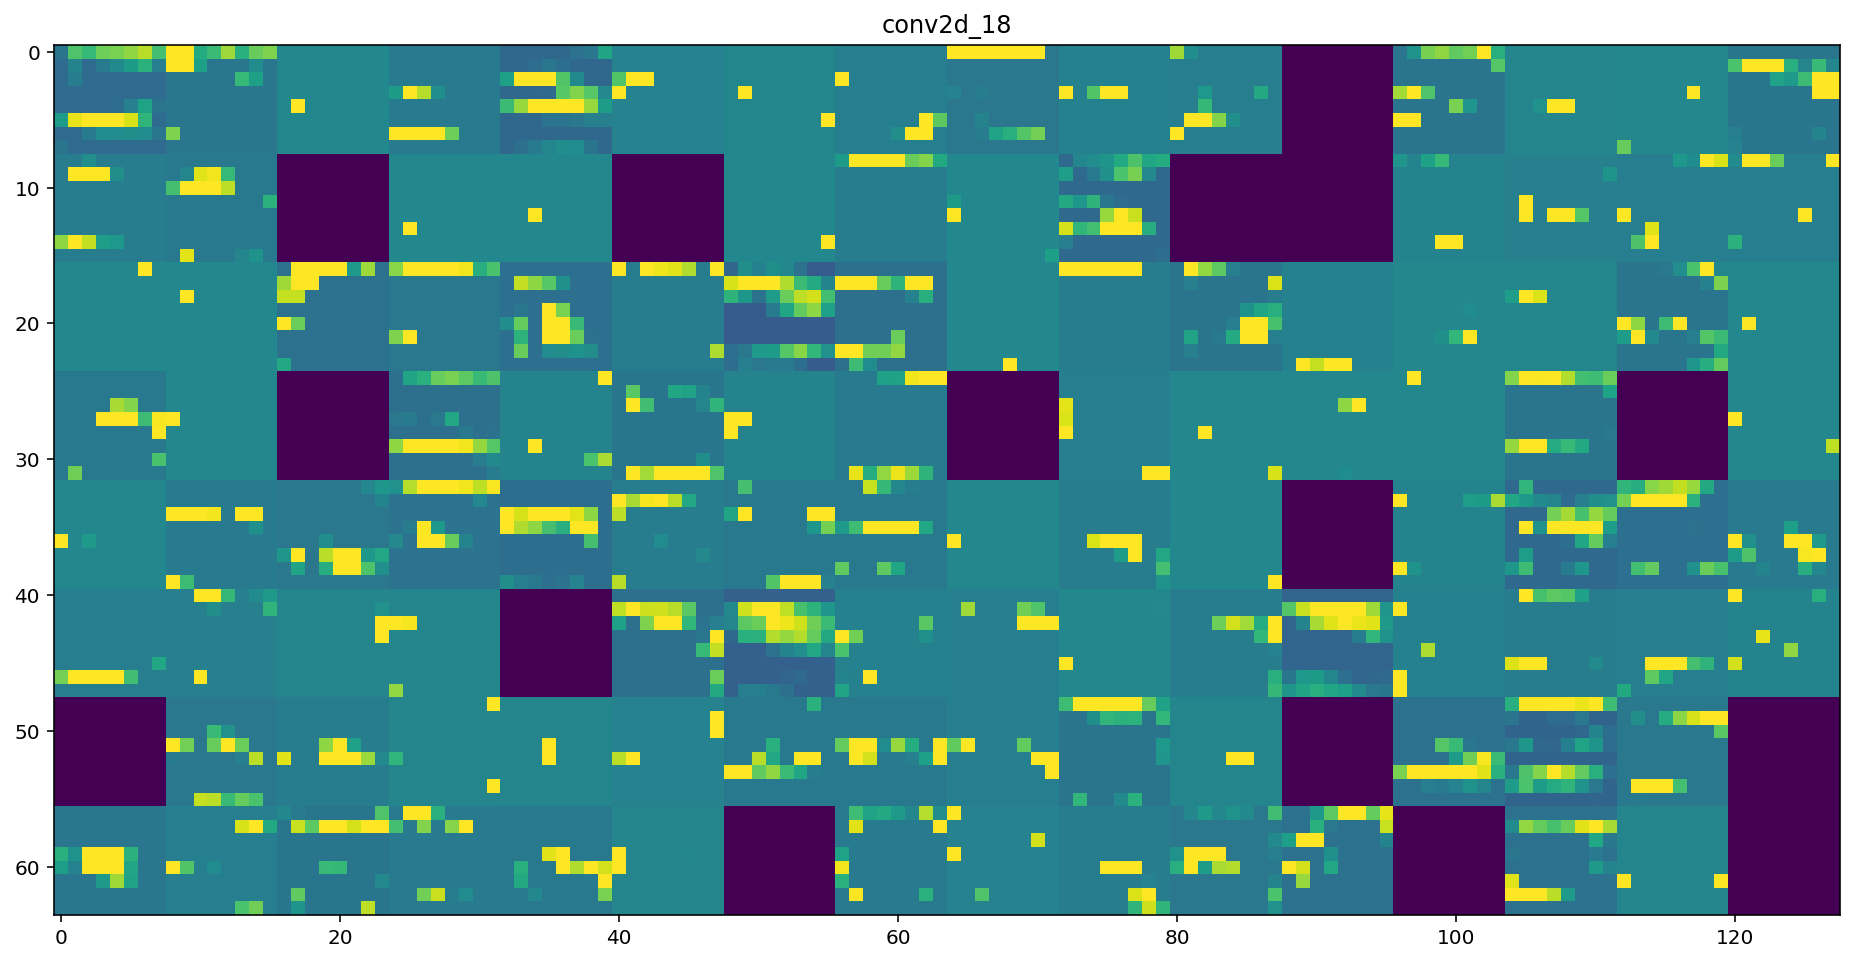

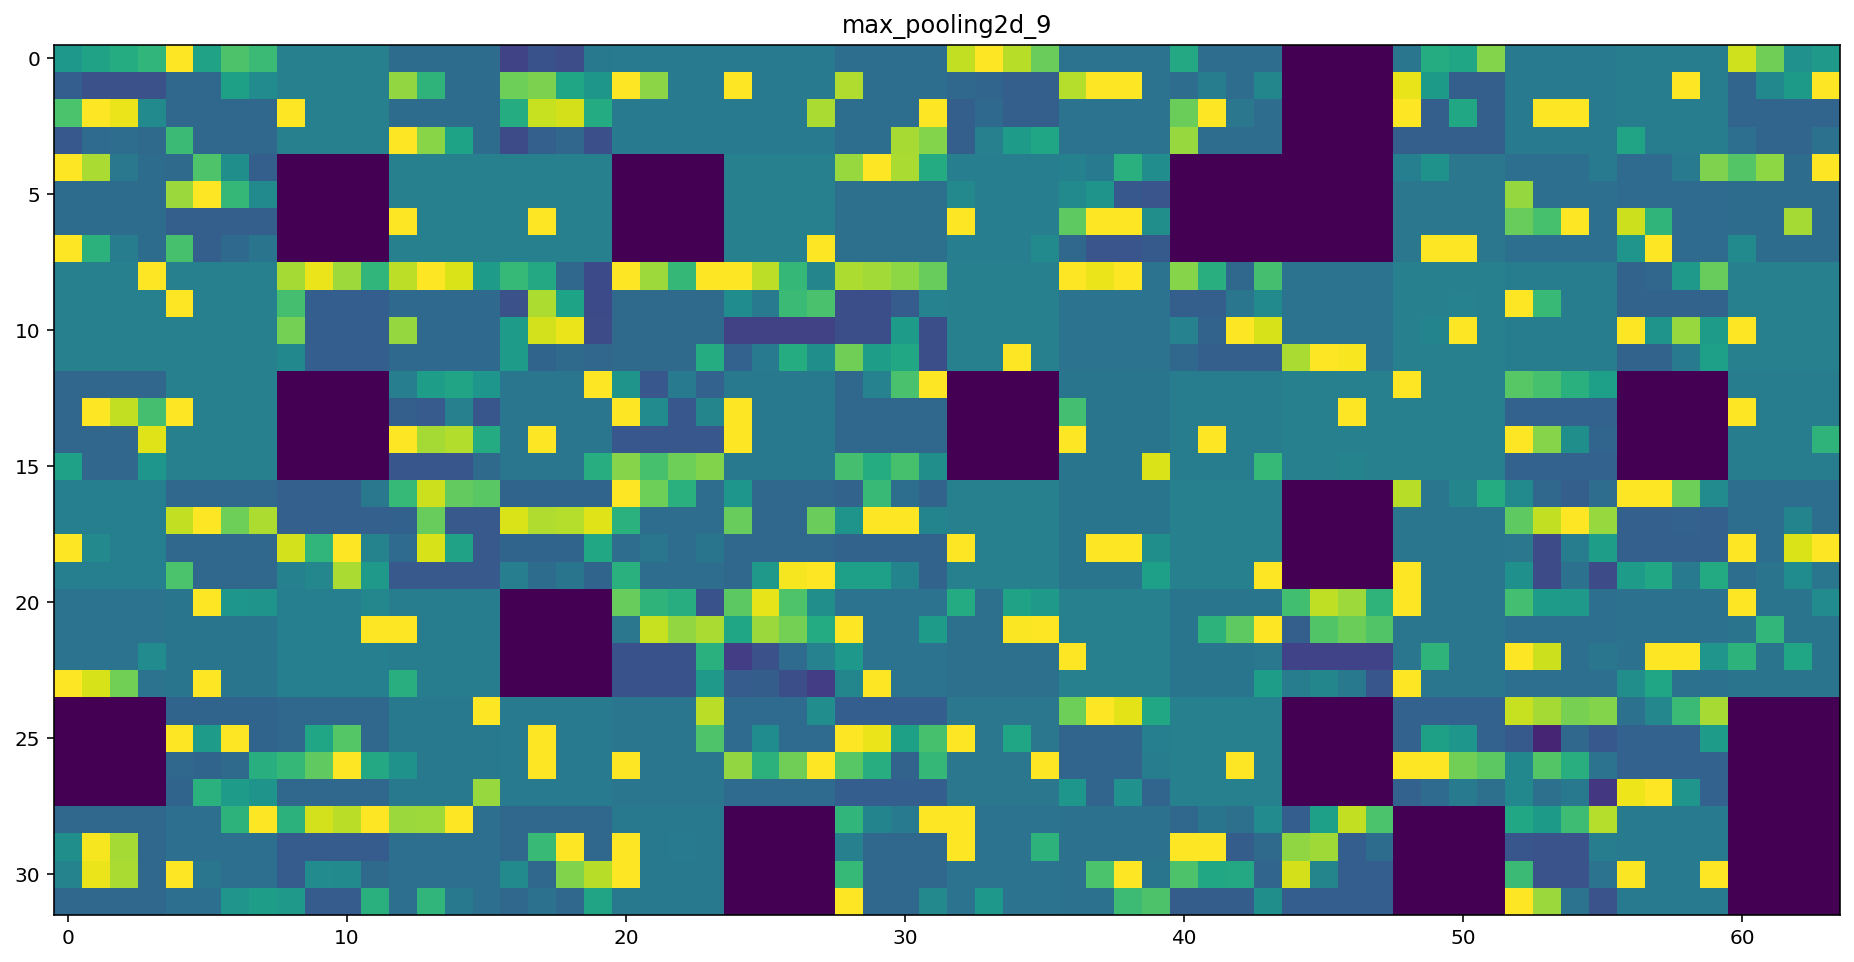

In [55]:
layer_names = []
for layer in model.layers[:12]:
    layer_names.append(layer.name) # Names of the layers, so you can have them as part of your plot
images_per_row = 16
for layer_name, layer_activation in zip(layer_names, activations): # Displays the feature maps
    n_features = layer_activation.shape[-1] # Number of features in the feature map
    size = layer_activation.shape[1] #The feature map has shape (1, size, size, n_features).
    n_cols = (n_features // images_per_row) # Tiles the activation channels in this matrix
    display_grid = np.zeros((size * n_cols, images_per_row * size))
    for col in range(n_cols): # Tiles each filter into a big horizontal grid
        for row in range(images_per_row):
            channel_image = layer_activation[0,
                                             :, :,
                                             col * images_per_row + row]
            channel_image -= channel_image.mean() # Post-processes the feature to make it visually palatable
            channel_image /= channel_image.std()
            channel_image *= 64
            channel_image += 128
            channel_image = np.clip(channel_image, 0, 255).astype('uint8')
            display_grid[col * size : (col + 1) * size, # Displays the grid
                         row * size : (row + 1) * size] = channel_image
    scale = 1. / size
    plt.figure(figsize=(scale * display_grid.shape[1],
                        scale * display_grid.shape[0]))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')